In [13]:
import tensorflow as tf 
import numpy as np 
import math
import os 
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.cluster import KMeans 
import seaborn as sns 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve,auc 
from sklearn.metrics import (auc, average_precision_score,  roc_auc_score, roc_curve, precision_recall_curve) 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.iforest import IForest
from sklearn.cluster import DBSCAN

In [14]:
def plot_metrics_curvesm(y_true, y_pred_roc, y_pred_prc, title='',saveloc='', label_extra='',**kwargs):
    """
    Plots roc and precision-recall curves

    Arguments
    =========
    y_true (iterator) : actual labels
    y_pred (iterator) : predicted labels
    title (str) : title for subplots
    **kwargs are for plt.plot()

    """
    x_roc, y_roc, _ = roc_curve(y_true, y_pred_roc)
    y_prc, x_prc, _ = precision_recall_curve(y_true, y_pred_prc)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].plot(x_roc, y_roc, color='darkorange', lw=2,
                label='{}ROC curve (area {:.2f})'.format(label_extra, roc_auc_score(y_true, y_pred_roc)),
                            **kwargs)
    axs[1].plot(x_prc, y_prc, color='darkorange', lw=2,
                label='{}PRC curve (area {:.2f})'.format(label_extra, average_precision_score(y_true, y_pred_prc)),
                            **kwargs)
    for ax, labels in zip(axs, (('FPR', 'TPR (recall)'), ('TPR (recall)', 'precision'))):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.legend(loc="lower right")
    plt.suptitle(title + 'N={} (frac_pos={:.2%})'.format(len(y_true), y_true.mean()))
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.9))
    plt.savefig(saveloc)
    plt.show()

In [15]:
def mad(X):
    """ calculates the median over the first axis, of the column-wise normalized 
    absolute deviation (normalized by iqr)
    """
    iqr =  np.quantile(X, 0.75, axis=0) - np.quantile(X, 0.25, axis=0)
    #the IQR may be zero. To avoid inf, fill with the variance
    iqr[np.where(iqr==0)] = np.var(X, axis=0)[np.where(iqr==0)] 
    return np.median(np.abs(X)/(iqr+0.00000001), axis=1)

def generate_auc_ap_tuple(X, y):
    return roc_auc_score(y, mad(X)), average_precision_score(y, mad(X))

# German Credit Data with Preprocessing

In [16]:
def MaxMin_Scaling(Data,name):
    Data[name]=(df[name]-df[name].min())/(df[name].max()-df[name].min())

def conver2onehot(data,name):
    newaddedlist=[]
    for i in range(len(data[name])):
        newadded = name + '_' + str(data[name][i]) 
        if newadded not in data.columns:
            data[newadded]=data[name]
            newaddedlist.append([newadded,data[name][i]])
    for i in range(len(data[name])):
        for addedname in newaddedlist:
            if data[addedname[0]][i]!=addedname[1]:
                data[addedname[0]][i]=0
            else:
                data[addedname[0]][i]=1
    data=data.drop([name],axis=1)
    return data
def Combine2va(data,name,c1,c2):
    #combine c2 into c1
    data1=data.copy()
    for i in range(len(data1[name])): 
        if data1[name][i]==c2:
            data1[name][i]=c1
    return data1

In [17]:
#loading data Geman  
df = pd.read_csv('german_credit.csv')
label=df['Creditability']
Data=df.drop(['Foreign Worker'],axis=1)
Data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone
0,1,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,1,1
1,1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,2,1
2,1,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1,1
3,1,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,2,1
4,1,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,1,1


In [18]:
# # # deal with Account Balance
Data1=Combine2va(Data,'Account Balance',3,4)
Data1=conver2onehot(Data1,'Account Balance')

# deal with Payment Status of Previous Credit
Data1=Combine2va(Data1,'Payment Status of Previous Credit',0,1)
Data1=Combine2va(Data1,'Payment Status of Previous Credit',0,3)
Data1=Combine2va(Data1,'Payment Status of Previous Credit',0,4)
Data1=conver2onehot(Data1,'Payment Status of Previous Credit')
# deal with Value Savings/Stocks
Data1=Combine2va(Data1,'Value Savings/Stocks',3,4)
Data1=conver2onehot(Data1,'Value Savings/Stocks') 
# Deal with Length of current employment
Data1=Combine2va(Data1,'Length of current employment',1,2)
Data1=conver2onehot(Data1,'Length of current employment') 
# Deal with Instalment per cent
Data1=conver2onehot(Data1,'Instalment per cent')
# # Deal with Occupation
Data1=Combine2va(Data1,'Occupation',1,2)
Data1=conver2onehot(Data1,'Occupation')
# # Deal with Sex & Marital Status
Data1=Combine2va(Data1,'Sex & Marital Status',1,2)
Data1=conver2onehot(Data1,'Sex & Marital Status')
# # Deal with Duration in Current address 
Data1=conver2onehot(Data1,'Duration in Current address')
# # Deal with Type of apartment
Data1=conver2onehot(Data1,'Type of apartment')  
# # # Deal with Most valuable available asset
Data1=conver2onehot(Data1,'Most valuable available asset')
# # Deal with No of Credits at this Bank
Data1=Combine2va(Data1,'No of Credits at this Bank',2,3)
Data1=Combine2va(Data1,'No of Credits at this Bank',2,4)
Data1=conver2onehot(Data1,'No of Credits at this Bank')
# # Deal with Guarantors
Data1=Combine2va(Data1,'Guarantors',2,3)
Data1=conver2onehot(Data1,'Guarantors')
# Deal with Concurrent Credits
Data1=Combine2va(Data1,'Concurrent Credits',1,2)
Data1=conver2onehot(Data1,'Concurrent Credits')
# Deal with No of dependents
Data1=conver2onehot(Data1,'No of dependents') 
# # Deal with Telephone
Data1=conver2onehot(Data1,'Telephone')
# Deal with Purpose 
Data1=Combine2va(Data1,'Purpose',3,7)
Data1=Combine2va(Data1,'Purpose',3,6)
Data1=Combine2va(Data1,'Purpose',3,5)
Data1=Combine2va(Data1,'Purpose',3,4)
Data1=conver2onehot(Data1,'Purpose') 


# MaxMin_Scaling
#MaxMin_Scaling(Data1,'Duration of Credit (month)') # will be better if don't added it
MaxMin_Scaling(Data1,'Credit Amount') #  will be better if added it
MaxMin_Scaling(Data1,'Age (years)') # no influence

In [19]:
Data1=Data1.drop(['Creditability'],axis=1)
print(Data1.head())
Data0=tf.transpose(np.array(Data1),[1,0])
y=np.array(1-label)
retio_intrinsic=1-np.sum(y)/len(y) 
print("retio of intrinsic samples: {}".format(retio_intrinsic)) 
print(np.shape(Data0))
print(np.shape(y))

   Duration of Credit (month)  Credit Amount  Age (years)  Account Balance_1  \
0                          18       0.043964     0.035714                  1   
1                           9       0.140255     0.303571                  1   
2                          12       0.032519     0.071429                  0   
3                          12       0.103004     0.357143                  1   
4                          12       0.105700     0.339286                  1   

   Account Balance_2  Account Balance_3  Payment Status of Previous Credit_0  \
0                  0                  0                                    1   
1                  0                  0                                    1   
2                  1                  0                                    0   
3                  0                  0                                    1   
4                  0                  0                                    1   

   Payment Status of Previous Credit_2

In [20]:
np.random.seed(0)
fraudindex=Data1[y==1].index
nonfraudindex=Data1[y==0].index
random_fraudindex=np.array(np.random.choice(fraudindex,300))
random_nonfraudindex=np.array(np.random.choice(nonfraudindex,700))

In [21]:
test_fraudindex=random_fraudindex[0:150]
test_nonfraudindex=random_nonfraudindex[0:350]
test_index=np.concatenate([test_fraudindex,test_nonfraudindex])
testData=Data1.iloc[test_index,:]
testy=y[test_index]
train_fraudindex=random_fraudindex[150:300]
train_nonfraudindex=random_nonfraudindex[350:700]
train_index=np.concatenate([train_fraudindex,train_nonfraudindex])
trainData=Data1.iloc[train_index,:] 
trainy=y[train_index]

In [22]:
print(testy)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# Logistic Regression

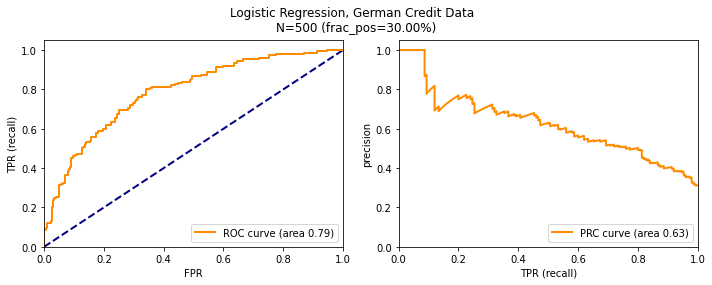

In [13]:
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc
 
lr_model=LogisticRegression()
lr_model.fit(trainData,trainy) 
y_pred_score=lr_model.predict_proba(testData)
y_pred_roc=y_pred_score[:,1]
y_pred_prc=y_pred_score[:,1]
plot_metrics_curvesm(np.array(testy), y_pred_roc, y_pred_prc, title='Logistic Regression, German Credit Data  \n',saveloc='LRGerman.jpg')

# Median Absolute Deviation from the Median (MAD)

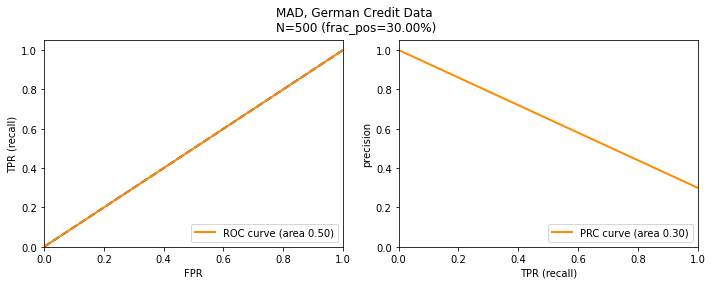

In [14]:
X_downsampled = np.array(testData)  
y_pred_roc=mad(X_downsampled)
y_pred_prc=mad(X_downsampled) 
plot_metrics_curvesm(np.array(testy), y_pred_roc, y_pred_prc, title='MAD, German Credit Data \n',saveloc='MADGerman.jpg')

# Gussian Mixture Model (for outlier detection)

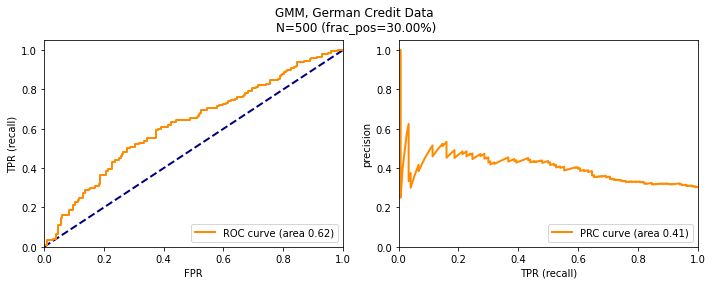

In [15]:
gm=GaussianMixture(n_components=34,random_state=4, reg_covar=1e-2) 
gm.fit(testData)
y_pred_roc=gm.score_samples(testData) 

gm=GaussianMixture(n_components=34,random_state=4, reg_covar=1e-2) 
gm.fit(testData)
y_pred_prc=gm.score_samples(testData)
 
plot_metrics_curvesm(np.array(testy), y_pred_roc, y_pred_prc, title='GMM, German Credit Data \n',saveloc='GMMGerman.jpg')

#  Local Outlier Factor (LOF)

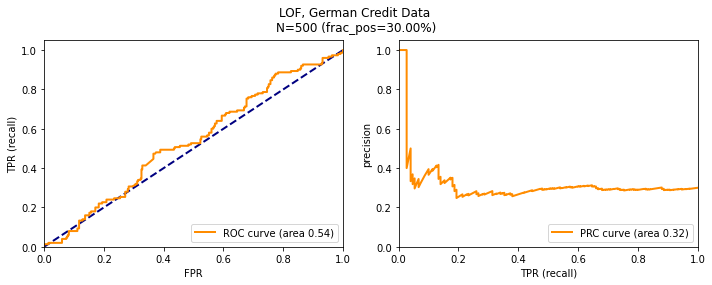

In [16]:
lofm = LOF(n_neighbors = int(4)) 
lofm.fit(testData)
y_pred=lofm.predict(testData)
y_pred_roc=lofm.decision_function(testData)

lofm = LOF(n_neighbors = int(30)) 
lofm.fit(testData)
y_pred=lofm.predict(testData)
y_pred_prc=lofm.decision_function(testData)

 

plot_metrics_curvesm(np.array(testy), -y_pred_roc, y_pred_prc, title='LOF, German Credit Data \n',saveloc='LOFGerman.jpg')

#  Isolation Forest (iForest)

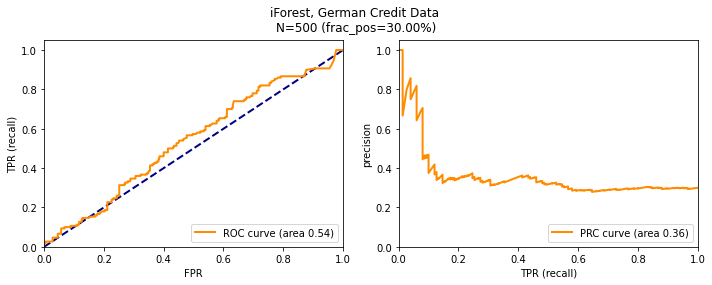

In [17]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=int(4), max_samples='auto', contamination=0.05, max_features=4,bootstrap=False, n_jobs=-1, random_state=1)
iforest.fit(testData)
y_pred=iforest.predict(testData)
y_pred_roc=iforest.decision_function(testData) 


iforest = IsolationForest(n_estimators=int(19), max_samples='auto', contamination=0.05, max_features=4,bootstrap=False, n_jobs=-1, random_state=1)
iforest.fit(testData)
y_pred=iforest.predict(testData)
y_pred_prc=iforest.decision_function(testData) 
 

plot_metrics_curvesm(np.array(testy), -y_pred_roc,y_pred_prc, title='iForest, German Credit Data \n',saveloc='iForestGerman.jpg')

# DBSCAN

In [18]:
def downsample_scale_split_df(df_full, y_column='Class', frac_negative=1, frac_positive=1, scaler=RobustScaler,
                        random_state=1, verbose=False):
    """ Returns downsampled X, y DataFrames, with prescribed downsampling of positives and negatives
    The labels (y's) should have values 0, 1 and be located in y_column
    X will additionally be scaled using the passed scaler

    Arguments
    =========
    df_full (pd.DataFrame) : data to be processed
    y_column (str) : name of the column containing the Class
    frac_negative (int): fraction of negatives in returned data
    frac_positive (int): fraction of negatives in returned data
    scaler (sci-kit learn scaler object)

    Returns
    ========
    downsampled and scaled X (DataFrame) and downsampled y (Series)
    """
    df_downsampled = (pd.concat([df_full.loc[df_full[y_column] == 0].sample(frac=frac_negative,
                                                                        random_state=random_state),
                                df_full.loc[df_full[y_column] == 1].sample(frac=frac_positive,
                                                                       random_state=random_state)])
                              .sample(frac=1, random_state=random_state)) # a random shuffle to mix both classes
    X_downsampled = df_downsampled.loc[:, df_full.columns != y_column]
    y_downsampled = df_downsampled.loc[:, y_column]
    if scaler is not None:
        X_downsampled = scaler().fit_transform(X_downsampled) # Scale the data
    if verbose:
        print('Number of points: {}, number of positives: {} ({:.2%})'.format(
            len(y_downsampled), y_downsampled.sum(), y_downsampled.mean()))
    return(X_downsampled, y_downsampled)

In [19]:
# Run this for various min_samples and epsilon
def dbscan_scan(X, y, min_samples_list=(5, 10), epsilon_list=(1, 2, 5, 10), random_state=None):
    """ A scan function for DBSCAN. Iterates over min_samples_list and epsilon_list
    random_state (None or int) : if int, this will be set as a random seed and data will be shuffled
    """
    dbscan_dict = defaultdict(list)
    if random_state:
        np.random.seed(random_state)
        idx = np.random.choice(len(y), len(y), replace=False)
        X = X[idx, :]
        y = y[idx]

    for min_samples in min_samples_list:
        for epsilon in epsilon_list:            
            print('calculating result for epsilon {}, min_samples {}...'.format(
            epsilon, min_samples))
            
            # dbscan_outlier_pred returns 1 for the outlier class, and 0 for the main "inlier" class
            y_predicted = dbscan_outlier_pred(X, epsilon=epsilon, min_samples=min_samples) 
            auc_db = roc_auc_score(y_true=y, y_score=y_predicted)
            pr_db = average_precision_score(y_true=y, y_score=y_predicted)
            num_clusters = len(set(y_predicted))
            precision_outlier_class = y[y_predicted == 1].mean()
            size_outlier_cluster = np.sum(y_predicted == 1)

            # store results in a DataFrame
            
            for k, v in (('epsilon', epsilon), ('min_samples', min_samples), ('AUC', auc_db), 
                         ('num_clusters', num_clusters), ('size_outlier_cluster', size_outlier_cluster), 
                         ('AP', pr_db), ('precision_outlier_class', precision_outlier_class),
                         ('random_state', random_state)):
                dbscan_dict[k].append(v)
        dbscan_results_df = pd.DataFrame.from_dict(dbscan_dict)

    return dbscan_results_df

In [20]:
def dbscan_outlier_pred(X, epsilon=0.3, min_samples=10, **kwargs):
    db = DBSCAN(eps=epsilon, min_samples=min_samples, **kwargs)
    db.fit(X)
    return labels_from_DBclusters(db)

In [21]:
def labels_from_DBclusters(db):
    """
    Returns labels for each point for "outlierness", based on DBSCAN results.
    The higher the score, the more likely the point is an outlier, based on its cluster membership
    
    - dbscan label -1 (outliers): highest score of 1
    - largest cluster gets score 0  
    - points belonging to clusters get a score that is higher when the cluster size is smaller
    
    db: a fitted DBscan instance
    Returns: labels (similar to "y_predicted", but the values merely reflect a ranking)
    """
    labels = np.zeros(len(db.labels_))
    
    # make a list of tuples: (i, num points in i) for i in db.labels_
    label_counts = [(i, np.sum(db.labels_==i)) for i in set(db.labels_) - set([-1])]
    label_counts.sort(key=lambda x : -x[1]) # sort by counts per class, descending
    
    # assign the labels. Those points with label =-1 get highest label (equal to number of classes -1) 
    labels[db.labels_== -1] = len(set(db.labels_)) - 1
    for i, (label, label_count) in enumerate(label_counts):
        labels[db.labels_==label] = i
        
    # Scale the values between 0 and 1
    labels = (labels - min(labels)) / (max(labels) - min(labels)+0.00000001)
    return(labels) 

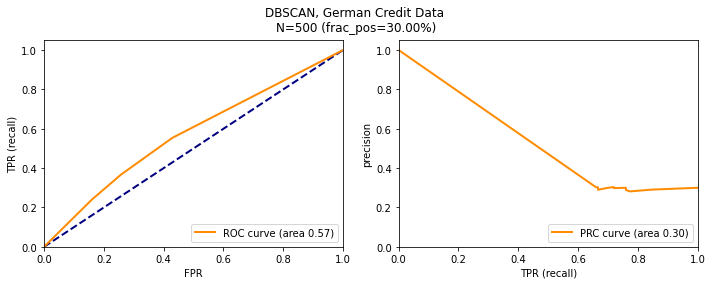

In [23]:
X_downsampled = testData #RobustScaler().fit_transform(X_test)
y_pred_roc = dbscan_outlier_pred(X_downsampled, min_samples=15, epsilon=4.0) 

X_downsampled = testData #RobustScaler().fit_transform(X_test)
y_pred_prc = dbscan_outlier_pred(X_downsampled, min_samples=5, epsilon=3.0) 

 

plot_metrics_curvesm(np.array(testy), y_pred_roc,y_pred_prc, title='DBSCAN, German Credit Data \n',saveloc='DBSCANGerman.jpg')

# Principal Component Analysis (PCA)

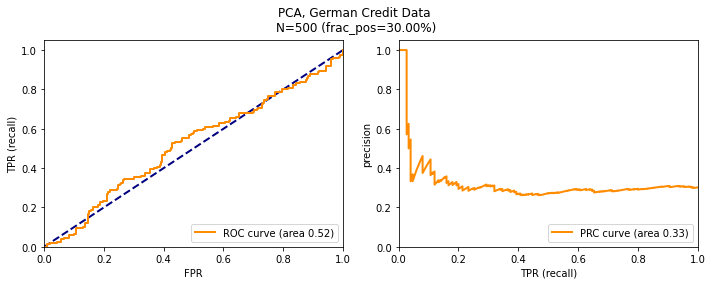

In [24]:
pca = PCA()
pca.fit(testData)
transformed_data = pca.transform(testData)
Data = transformed_data 
lambdas = pca.singular_values_
M = ((Data*Data)/lambdas)  
y_pred_roc=np.sum(M,axis=1)  

pca = PCA()
pca.fit(testData)
transformed_data = pca.transform(testData)
Data = transformed_data 
lambdas = pca.singular_values_
M = ((Data*Data)/lambdas)  
y_pred_prc=np.sum(M,axis=1) 

 
plot_metrics_curvesm(np.array(testy), -y_pred_roc,y_pred_prc, title='PCA, German Credit Data \n',saveloc='PCAGerman.jpg')

# OP Model_L1

In [23]:
 #OP Model with L1 norm
from tensorflow.python.ops.linalg_ops import norm_v2
class OP_main():
    
    def __init__(self,Data, lam,th=0.000000000000001, rho=1.5, mup=1.25): 


        n1,n2=np.shape(Data)
        self.lam=lam #1/np.sqrt(n1)
        self.eps=0.000000000000001
        self.d_nrom=norm_v2(Data)
        norm_two=np.linalg.svd(Data,compute_uv=False)[0]#norm_v2(Data,2) 
        norm_inf=norm_v2(Data,np.inf)/self.lam 
        dual_norm=np.max([norm_two, norm_inf])
        Lambda_int=Data/dual_norm 
        self.mu=mup/norm_two #1.25
        self.maxmu=self.mu*10**(7)
        self.rho=rho #1.5
        self.stages=200 
        self.tol=10**(-7) 
        
        
        X_int, E_int= tf.zeros([n1,n2], tf.float32), tf.zeros([n1,n2], tf.float32)
        value_sets=(Data, X_int, E_int, Lambda_int)
        self.FX, self.FE = self.OP_ADMM_main(value_sets) 
        self.Elabel=self.getLable(self.FE,th)
 
    def OP_ADMM_main(self, inputs):
        (Data, X_int, E_int, Lambda_int) = inputs  
        self.X,self.E,self.Lambda  = [],[],[]  
        self.E.append(self.Updata_E(Data, X_int, Lambda_int))  
        self.X.append(self.Updata_X(Data, self.E[-1], Lambda_int))      
        self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], Lambda_int))  
        self.mu=np.min([self.mu*self.rho, self.maxmu]) 
        for stage in range(1,self.stages): 
            self.E.append(self.Updata_E(Data, self.X[-1], self.Lambda[-1]))  
            self.X.append(self.Updata_X(Data, self.E[-1], self.Lambda[-1]))      
            self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], self.Lambda[-1]))   
            self.mu=np.min([self.mu*self.rho, self.maxmu]) 
            stopCriterion= norm_v2(Data-self.X[-1]-self.E[-1])/self.d_nrom   
            if stopCriterion < self.tol:
                break 
        print("Stop Criterion: {}".format(stopCriterion))
        return self.X[-1], self.E[-1]   
     

     

    def Updata_X(self,Data, E, Lambda):
        
        temp=-E+Data+Lambda/self.mu  
        return self.SVT(temp,1/self.mu)

 
   
    def SVT(self,X,th):
        n1, n2= np.shape(X)
        rank=np.min([n1,n2])  
        U_int, S_int, VT_int=np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
        S_int=tf.nn.relu(S_int-tf.multiply(th,tf.ones(np.shape(S_int), tf.float32)))
        rank=len(np.where(S_int > self.eps)[0])
        if rank==0:
            rank=1  
        S_int=tf.compat.v1.matrix_diag(S_int) 
        Ak_int=tf.matmul(tf.matmul(U_int[:,0:rank],S_int[0:rank,0:rank]),VT_int[0:rank,:]) 
          
        return Ak_int    
 
    def Updata_E(self, Data, X, Lambda):
      
        Temp= Data-X+Lambda/self.mu
        return self.sparse_col(  Temp, self.lam/self.mu)
 

   

    def sparse_col(self, E, tau): 
        result=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            result.append(tf.nn.relu(tf.norm(E[:,i])-tau)*E[:,i]/(tf.norm(E[:,i])+self.eps)) 
        return tf.transpose(result,[1,0])

  
     

    def Updata_Lambda(self, Data, X, E, Lambda):
        Lambda= Lambda+tf.multiply(self.mu, Data-X-E)
        return Lambda
 

    def getLable(self, E,th): 
        Elabel=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            if tf.norm(E[:,i])>th:
                Elabel.append(0)
            else:
                Elabel.append(1)
        return Elabel
         
    def getLable2(self, E,num=300): 
        Elabel=[]
        Enum=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            Enum.append(tf.norm(E[:,i]))
        ind = np.argpartition(Enum, -num)[-num:]
        for i in range(n2):
            if i in ind:
                Elabel.append(1)
            else:
                Elabel.append(0)
        return Elabel
    
def getEnorm(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(tf.norm(E[:,i])) 
    return  Enum
def normlize(Data):
    newData=[]
    n1,n2=np.shape(Data)
    for i in range(n2):
        newData.append(Data[:,i]/tf.norm(Data[:,i])) 
    return  tf.transpose(newData,[1,0])
def getMax(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(np.max(E[:,i])) 
    return  Enum

Stop Criterion: 4.746502568764299e-08
Stop Criterion: 4.746502568764299e-08


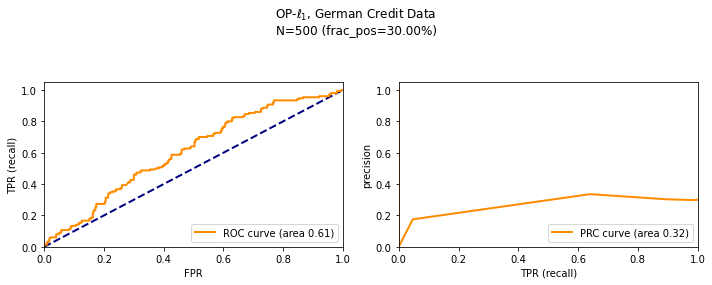

In [24]:
Data0=tf.transpose(np.array(testData),[1,0])
Data0=normlize(tf.cast(Data0,tf.float32))


H=OP_main(Data0, 0.02)  
y_score=getMax(H.FE)
y_pred_roc= y_score/np.max(y_score)

H=OP_main(Data0, 0.02)  
y_score=getEnorm(H.FE)
y_pred_prc= y_score/np.max(y_score)
     
plot_metrics_curvesm(np.array(testy), y_pred_roc,y_pred_prc, title='OP-$\ell_1$, German Credit Data \n',saveloc='OPL1German.jpg')

# OP Model_Lp

In [11]:
#OP model with GST
from tensorflow.python.ops.linalg_ops import norm_v2
class OPGST_main():
    
    def __init__(self, Data, lam,p=1,th=0.000000000000001, rho=1.5, mup=1.25):
        
    

        self.p=p
        n1,n2=np.shape(Data)
        self.lam=lam #1/np.sqrt(n1)
        self.eps=0.000000000000001
        self.d_nrom=norm_v2(Data)
        norm_two=np.linalg.svd(Data,compute_uv=False)[0]#norm_v2(Data,2) 
        norm_inf=norm_v2(Data,np.inf)/self.lam 
        dual_norm=np.max([norm_two, norm_inf])
        Lambda_int=Data/dual_norm 
        self.mu=mup/norm_two #1.25
        self.maxmu=self.mu*10**(7)
        self.rho=rho #1.5
        self.stages=200 
        self.tol=10**(-7) 
        
        X_int, E_int= tf.zeros([n1,n2], tf.float32), tf.zeros([n1,n2], tf.float32)
        value_sets=(Data, X_int, E_int, Lambda_int)
        self.FX, self.FE = self.OP_ADMM_main(value_sets) 
        self.Elabel=self.getLable(self.FE,th)
 
    def OP_ADMM_main(self, inputs):
        (Data, X_int, E_int, Lambda_int) = inputs  
        self.X,self.E,self.Lambda  = [],[],[]  
        self.E.append(self.Updata_E(Data, X_int, Lambda_int))  
        self.X.append(self.Updata_X(Data, self.E[-1], Lambda_int))      
        self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], Lambda_int))  
        self.mu=np.min([self.mu*self.rho, self.maxmu]) 
        for stage in range(1,self.stages): 
            self.E.append(self.Updata_E(Data, self.X[-1], self.Lambda[-1]))  
            self.X.append(self.Updata_X(Data, self.E[-1], self.Lambda[-1]))      
            self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], self.Lambda[-1]))   
            self.mu=np.min([self.mu*self.rho, self.maxmu]) 
            stopCriterion= norm_v2(Data-self.X[-1]-self.E[-1])/self.d_nrom  
            if stopCriterion < self.tol:
                break 
        print("Stop Criterion: {}".format(stopCriterion)) 
        return self.X[-1], self.E[-1]   
     

     

    def Updata_X(self,Data, E, Lambda): 
      
        temp=-E+Data+Lambda/self.mu  
        return self.SVT(temp,1/self.mu)

 
   
    def SVT(self,X,th):
        n1, n2= np.shape(X)
        rank=np.min([n1,n2])  
        U_int, S_int, VT_int=np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
        S_int=self.Generalized_Soft_Thresholding(S_int,th,self.p)
        rank=len(np.where(S_int > self.eps)[0])
        if rank==0:
            rank=1  
        S_int=tf.compat.v1.matrix_diag(S_int) 
        Ak_int=tf.matmul(tf.matmul(U_int[:,0:rank],S_int[0:rank,0:rank]),VT_int[0:rank,:]) 
          
        return Ak_int    
 
    def Updata_E(self, Data, X, Lambda):
        
        Temp= Data-X+Lambda/self.mu
        return self.sparse_col(  Temp, self.lam/self.mu)
 

   

    def sparse_col(self, E, tau): 
        result=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            result.append(self.Generalized_Soft_Thresholding(tf.norm(E[:,i]),tau,self.p)*E[:,i]/(tf.norm(E[:,i])+self.eps)) 
        return tf.transpose(result,[1,0])

  
     

    def Updata_Lambda(self, Data, X, E, Lambda):
        Lambda= Lambda+tf.multiply(self.mu, Data-X-E)
        return Lambda
 

    def getLable(self, E,th): 
        Elabel=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            if tf.norm(E[:,i])>th:
                Elabel.append(1)
            else:
                Elabel.append(0)
        return Elabel
         
        
    def Generalized_Soft_Thresholding(self,S,weight,p):
        #diagS: a vector
        #weight: a value
        if np.shape(S) == ():
            diagS=[S]
        else:
            diagS=S 
        J=5 
        sigma0   =    np.abs(diagS)
        tau_GST  =   (2*weight*(1-p))**(1/(2-p))   +   p*weight*(2*(1-p)*weight)**((p-1)/(2-p)) 
        Delta=[];
        for i in range(len(diagS)):
                if sigma0[i]>tau_GST: 
                    delta=sigma0[i]  
                    for k in range(J): 
                            delta=sigma0[i]-weight*p*delta**(p-1)           
                            k=k+1  
                    Delta.append(np.sign(diagS[i])*delta)  
                else:
                    Delta.append(0) 
        if np.shape(S) == ():
            return np.array(Delta[0],np.float32) 
        else:
            return np.array(Delta,np.float32) 


def getEnorm(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(tf.norm(E[:,i])) 
    return  Enum
def normlize(Data):
    newData=[]
    n1,n2=np.shape(Data)
    for i in range(n2):
        newData.append(Data[:,i]/tf.norm(Data[:,i])) 
    return  tf.transpose(newData,[1,0])
def getMax(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(np.max(E[:,i])) 
    return  Enum    

Stop Criterion: 9.48222407259891e-08
Stop Criterion: 4.2499770813719806e-08


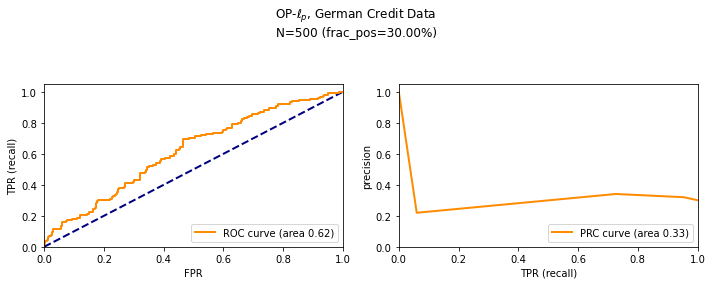

In [12]:
Data0=tf.transpose(np.array(testData),[1,0])
Data0=normlize(tf.cast(Data0,tf.float32))

HGST=OPGST_main(Data0,0.23, 0.85)
y_score=getMax(HGST.FE)
y_pred_roc= y_score/np.max(y_score)

HGST=OPGST_main(Data0,0.03, 0.75)
y_score=getEnorm(HGST.FE)
y_pred_prc= y_score/np.max(y_score)
     
plot_metrics_curvesm(np.array(testy), -y_pred_roc,y_pred_prc, title='OP-$\ell_p$, German Credit Data \n',saveloc='OPLpGerman.jpg')

# OP Model_ETP

In [29]:
#OP model with ETP
from tensorflow.python.ops.linalg_ops import norm_v2
class OPETP_main():
    
    def __init__(self, Data, lam, p=1, th=0.000000000000001, rho=1.5, mup=1.25,Maxiter=1000,tol=10**(-7)):
        
        #(Data, lam,th, rho, mup)=value_sets

        self.p=p
        n1,n2=np.shape(Data)
        self.lam=lam #1/np.sqrt(n1)
        self.eps=0.000000000000001
        self.d_nrom=norm_v2(Data)
        norm_two=np.linalg.svd(Data,compute_uv=False)[0]#norm_v2(Data,2) 
        norm_inf=norm_v2(Data,np.inf)/self.lam 
        dual_norm=np.max([norm_two, norm_inf])
        Lambda_int=Data/dual_norm 
        self.mu=mup/norm_two #1.25
        self.maxmu=self.mu*10**(7)
        self.rho=rho #1.5
        self.stages=200
        self.tol=10**(-7) 
        
        X_int, E_int= tf.zeros([n1,n2], tf.float64), tf.zeros([n1,n2], tf.float64)
        value_sets=(Data, X_int, E_int, Lambda_int)
        self.FX, self.FE = self.OP_ADMM_main(value_sets) 
        self.Elabel=self.getLable(self.FE,th)
 
    def OP_ADMM_main(self, inputs):
        (Data, X_int, E_int, Lambda_int) = inputs  
        self.X,self.E,self.Lambda  = [],[],[]  
        self.E.append(self.Updata_E(Data, X_int, Lambda_int))  
        self.X.append(self.Updata_X(Data, self.E[-1], Lambda_int))      
        self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], Lambda_int))  
        self.mu=np.min([self.mu*self.rho, self.maxmu]) 
        for stage in range(1,self.stages): 
            self.E.append(self.Updata_E(Data, self.X[-1], self.Lambda[-1]))  
            self.X.append(self.Updata_X(Data, self.E[-1], self.Lambda[-1]))      
            self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], self.Lambda[-1]))   
            self.mu=np.min([self.mu*self.rho, self.maxmu]) 
            stopCriterion= norm_v2(Data-self.X[-1]-self.E[-1])/self.d_nrom  
            if stopCriterion < self.tol:
                break 
        print("Stop Criterion: {}".format(stopCriterion)) 
        return self.X[-1], self.E[-1]   
     

     

    def Updata_X(self,Data, E, Lambda): 
      
        temp=-E+Data+Lambda/self.mu  
        return self.SVT(temp,1/self.mu)

 
   
    def SVT(self,X,th):
        n1, n2= np.shape(X)
        rank=np.min([n1,n2])  
        U_int, S_int, VT_int=np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
        S_int=self.GAI_ETP(S_int,th,self.p)
        rank=len(np.where(S_int > self.eps)[0])
        if rank==0:
            rank=1  
        S_int=tf.compat.v1.matrix_diag(S_int) 
        Ak_int=tf.matmul(tf.matmul(U_int[:,0:rank],S_int[0:rank,0:rank]),VT_int[0:rank,:]) 
          
        return Ak_int    
 
    def Updata_E(self, Data, X, Lambda): 
        Temp= Data-X+Lambda/self.mu 
        return self.sparse_col(  Temp, self.lam/self.mu)
 

   

    def sparse_col(self, E, tau): 
        result=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            result.append(self.GAI_ETP(tf.norm(E[:,i]),tau,self.p)*E[:,i]/(tf.norm(E[:,i])+self.eps)) 
        return tf.transpose(result,[1,0])

  
     

    def Updata_Lambda(self, Data, X, E, Lambda):
        Lambda= Lambda+tf.multiply(self.mu, Data-X-E)
        return Lambda
 

    def getLable(self, E,th): 
        Elabel=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            if tf.norm(E[:,i])>th:
                Elabel.append(1)
            else:
                Elabel.append(0)
        return Elabel
         
        
   

    def GAI_ETP(self,xi,lambd,gamma,Iter=10,tol=10**(-6)):
        #Iter=10; 
        a0=np.max([np.log((1-np.exp(-gamma))/(lambd*gamma**2))/(-gamma),0])
        #print(a0)
        delta=a0+self.ETP_gradient(a0,gamma,lambd)
        #print(delta) 
        if np.shape(xi) == ():
            x=[xi]
        else:
            x=xi
        n=len(x)
        y=[]
 

     
        for j in range(n):
            gradient_g= self.ETP_gradient(x[j],gamma,lambd)
            if gradient_g==0:
                BARx_b=x[j] 
            else:
                if delta<x[j]:
                    a=x[j]
                    sto=0
                    kkk=0
                    while sto==0:
                        kkk=kkk+1
                        a1=x[j]-self.ETP_gradient(a,gamma,lambd)
                        a2=x[j]-self.ETP_gradient(a1,gamma,lambd) 
                        if np.abs(a2-2*a1+a)<tol or kkk>=Iter:
                            if np.abs(a2-2*a1+a)<self.eps:
                                BARx_b=a2
                            else:
                                BARx_b=a1-(a2-a1)*(a1-a)/(a2-2*a1+a)
                            break
                        a=a1-(a2-a1)*(a1-a)/(a2-2*a1+a) 
                        #print(a)
                else:
                    BARx_b=a0
            if self.ETP_fun(BARx_b,x[j],gamma,lambd)<=self.ETP_fun(0,x[j],gamma,lambd):
                y.append(BARx_b)   
            else:
                y.append(0)
                    
        if np.shape(xi) == ():
            return np.array(y[0],np.float64) 
        else:
            return np.array(y,np.float64)
      
           
    #ETP's gradient 
    def ETP_gradient(self,x,gamma,lambd):
        gradient_g=gamma*lambd*np.exp(-gamma*x)/(1-np.exp(-gamma)) 
        return gradient_g
 
    def ETP_fun(self,x,y,gamma,lambd):
        g=1/2*(y-x)**2+lambd*(1-np.exp(-gamma*x))/(1-np.exp(-gamma))
        return g   


def getEnorm(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(tf.norm(E[:,i])) 
    return  Enum
def normlize(Data):
    newData=[]
    n1,n2=np.shape(Data)
    for i in range(n2):
        newData.append(Data[:,i]/tf.norm(Data[:,i])) 
    return  tf.transpose(newData,[1,0])
def getMax(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(np.max(E[:,i])) 
    return  Enum

Stop Criterion: 1.2561533992427693e-12
Stop Criterion: 2.058500239423862e-10


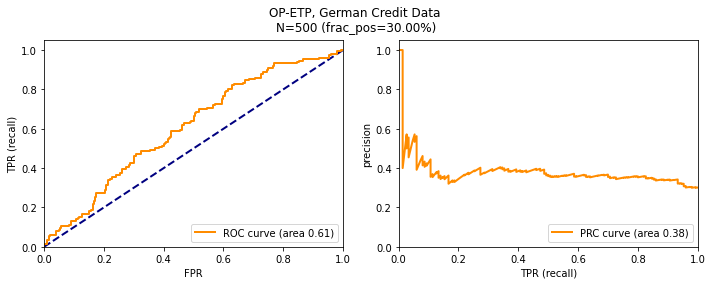

In [38]:
Data0=tf.transpose(np.array(testData),[1,0])
Data0=normlize(tf.cast(Data0,tf.float64))

OPETP=OPETP_main(Data0,0.02, 1e-08)
y_score=getMax(OPETP.FE)
y_pred_roc= y_score/np.max(y_score)

OPETP=OPETP_main(Data0, 0.04, 0.001)
y_score=getMax(OPETP.FE)
y_pred_prc= y_score/np.max(y_score)
     
plot_metrics_curvesm(np.array(testy), y_pred_roc,y_pred_prc, title='OP-ETP, German Credit Data \n',saveloc='OPETPGerman.jpg')